### 1.載入套件

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

### 2.載入資料並進行處理

In [3]:
# Load dataset
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

# Reshape size
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Normalize the range of featurs
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

### 3.架構VAE模型

In [99]:
enc_1 = Dense(200, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(200, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [100]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

* 抽樣函數

In [101]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [102]:
# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [103]:
# Define Decoder part of VAE
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(z_input))

In [104]:
x_hat = dec_1(dec_2(z))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 200)          157000      input_13[0][0]                   
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 2)            402         dense_30[0][0]                   
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 2)            402         dense_30[0][0]                   
___________________________________________________________________________________________

* Loss Function

In [105]:
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [106]:
VAE.compile(loss='MAE',
                    optimizer=Adam(7e-3),
                    metrics=['mse'])

In [107]:
VAE.fit(X_train, X_train, 
        batch_size=256, 
        epochs=20)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 68us/sample - loss: 51.4224 - mse: 0.0637
Epoch 2/20
60000/60000 [==============================] - 3s 52us/sample - loss: 46.6802 - mse: 0.0563
Epoch 3/20
60000/60000 [==============================] - 3s 53us/sample - loss: 44.8203 - mse: 0.0534
Epoch 4/20
60000/60000 [==============================] - 3s 55us/sample - loss: 42.8542 - mse: 0.0503
Epoch 5/20
60000/60000 [==============================] - 3s 55us/sample - loss: 41.7305 - mse: 0.0485
Epoch 6/20
60000/60000 [==============================] - 3s 55us/sample - loss: 40.9497 - mse: 0.0473
Epoch 7/20
60000/60000 [==============================] - 3s 54us/sample - loss: 40.4361 - mse: 0.0465
Epoch 8/20
60000/60000 [==============================] - 3s 51us/sample - loss: 39.9496 - mse: 0.0457
Epoch 9/20
60000/60000 [==============================] - 3s 52us/sample - loss: 39.5400 - mse: 0.0451
Epoch 10/20
60000/60000 [=========================

In [108]:
VAE.save_weights('VAE_model_weights5.h5')

In [109]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_30 (Dense)             (None, 200)               157000    
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 402       
Total params: 157,402
Trainable params: 157,402
Non-trainable params: 0
_________________________________________________________________


In [110]:
VAE_Decoder = Model(z_input, dec_1(dec_2(z_input)))

VAE_Decoder.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_33 (Dense)             (None, 200)               600       
_________________________________________________________________
dense_34 (Dense)             (None, 784)               157584    
Total params: 158,184
Trainable params: 158,184
Non-trainable params: 0
_________________________________________________________________


In [111]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(X_train[idx: idx+1]).squeeze()}")

第 50905 圖的 latent 表示為 [1.2936783  0.45929185]


In [112]:
indice = np.random.randint(X_train.shape[0],size=5000)

In [113]:
VAE_Encoder.predict(X_train[indice])

array([[ 0.548223  ,  0.6133486 ],
       [ 0.76238704, -1.9595269 ],
       [ 2.6415405 , -0.6527197 ],
       ...,
       [ 1.7207012 ,  0.9262007 ],
       [-1.0287209 ,  0.65741247],
       [ 0.4252515 ,  1.1773927 ]], dtype=float32)

In [114]:
#VAE_Encoder.predict(X_train[indice])

In [115]:
VAE_latents = VAE_Encoder.predict(X_train[indice])

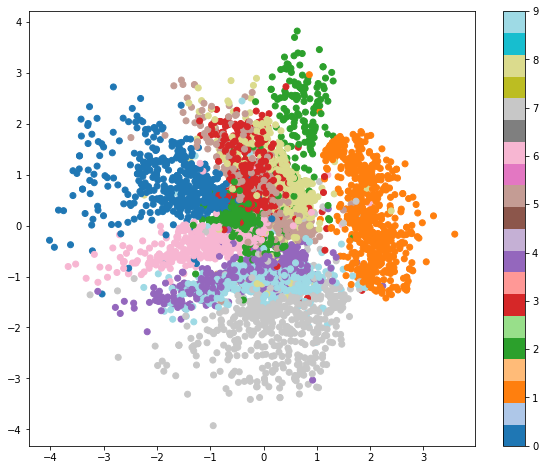

In [116]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indice], cmap='tab20')
plt.colorbar()
plt.show()

In [117]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [118]:
n=16
digit_size=28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

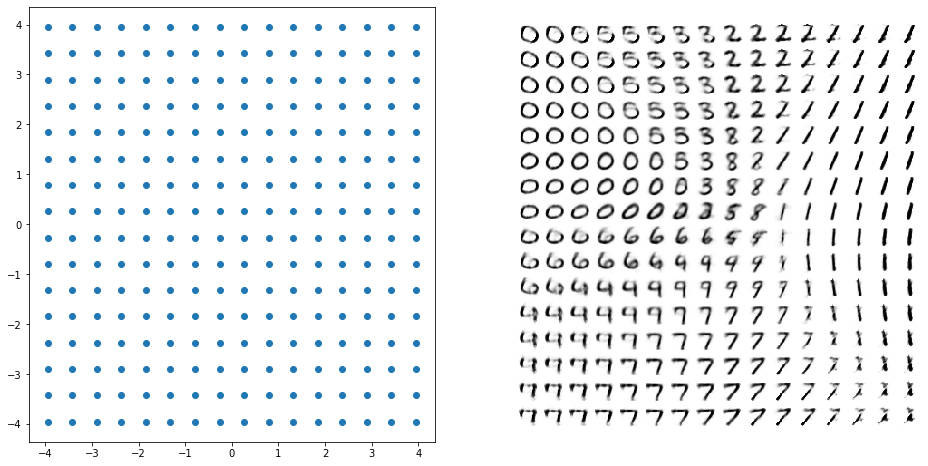

In [120]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()